In [1]:
# install GA lib
# !pip install geneticalgorithm

In [2]:
import numpy as np
from geneticalgorithm import geneticalgorithm as ga
from scipy.optimize import dual_annealing
from numpy import arange
from matplotlib import pyplot

%matplotlib inline

## 1- Optimize a simple function

In [3]:
def objective(x):
    return x[0]**2.0

In [4]:
# define range for input
r_min, r_max = [-5.0, 5.0]

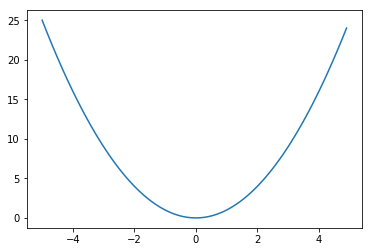

In [5]:
# plot function
inputs = arange(r_min, r_max, 0.1)
results = [objective([x]) for x in inputs]
pyplot.plot(inputs, results)

### 1-1 Simulated Annealing solution

In [6]:

maxiter = 200
seed = 123456
varbound=np.array([[-5,5]])
ret = dual_annealing(objective, bounds=varbound, maxiter=maxiter, seed=seed)
ret.x

array([1.26327748e-09])

In [7]:
ret.nit

200

In [8]:
ret.x

array([1.26327748e-09])

### 1-2 Genetic Algorithm solution

 The best solution found:
 [6.33573455e-07]

 Objective function:
 4.014153228397954e-13


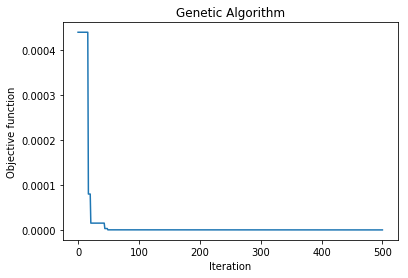

In [9]:
model=ga(function=objective,dimension=1,variable_type='real',variable_boundaries=varbound)

model.run()

## 2- Optimize a neural network model

In [10]:
import tensorflow as tf
from keras.datasets import boston_housing
from keras.layers import Input, Dense
from keras.engine import Model
from sklearn.metrics import mean_absolute_error


Using TensorFlow backend.


### 2-1 Boston prices data

In [11]:

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [12]:
train_data.shape

(404, 13)

In [13]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

### 2-2 NN model

In [14]:


def buildmodel(nhis, activation, ninputs):
    ins = Input(shape=(ninputs,), dtype='float32', name='inputs')
    layers=[]
    outs = ins
    for h in nhis:
        layer = Dense(h, activation=activation)
        outs= layer(outs)
    outs = Dense(1, activation='linear')(outs)
    model = Model([ins], outs)
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

activation = 'relu'
nhis=[5, 5]
ninputs= train_data.shape[1]
nn_model = buildmodel(nhis, activation, ninputs)
print (nn_model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 13)]              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 70        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 106
Trainable params: 106
Non-trainable params: 0
_________________________________________________________________
None


### 2-3 Gradient descent solution 

In [15]:
nn_model.fit(train_data,train_targets,epochs=200,batch_size=10,verbose=0)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [16]:
val_mse, val_mae = nn_model.evaluate(test_data, test_targets, verbose=1)
val_mse, val_mae

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - 0s 819us/step - loss: 20.3316 - mae: 3.0607


(20.331581115722656, 3.0607097148895264)

### 2-4 Simulated Annealing solution

In [17]:
def unflatten(flat_w, old_w):
    """ flat_w : 1D array of weights (flattened). old_w : output of model.get_weights(). """
    new_w = []
    i = 0
    for layer in old_w:
        size = layer.size
        new_w.append(flat_w[i:i+size].reshape(layer.shape))
        i += size
    return new_w

In [18]:
import collections
#https://shawnwanderson.github.io/Flattening-and-Unflattening-Keras-Weights/
def flatten(weights):
    w = []
    for l in weights:
        if isinstance(l, collections.Iterable):
            w = w + flatten(l)
        else:
            w = w + [l]
    return w

In [20]:
# try flatten and unflatten
w_vec  = flatten (nn_model.get_weights()) 
w_matrix = unflatten (np.array(w_vec), nn_model.get_weights())


In [21]:
def fitness_function(weights_vector):
    bce = tf.keras.losses.MeanAbsoluteError()
    weights_matrix = unflatten(np.array(weights_vector), nn_model.get_weights())
    nn_model.set_weights(weights_matrix)
    y_pred = nn_model.predict(train_data)
    loss = bce(train_targets, y_pred).numpy()
    fitness= -loss
    return loss

In [22]:
maxiter = 5
seed = 123456
weights_vector = flatten(nn_model.get_weights())
lw = [-1] * len(weights_vector)
up = [1] * len(weights_vector)
varbound=list(zip(lw, up))
ret = dual_annealing(fitness_function, bounds=varbound, maxiter=maxiter, seed=seed)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [23]:
best_solution = ret.x
weights_matrix = unflatten(np.array(best_solution), nn_model.get_weights())
nn_model.set_weights(weights_matrix)
y_pred = nn_model.predict(test_data)
mean_absolute_error(y_pred,test_targets )

7.927592266307157

### 2-4 GA solution

In [24]:
len(np.array(varbound))

106

 The best solution found:
 [ 0.52379049 -0.76343625 -0.56988238  0.65058927  0.47821331 -0.5787358
 -0.87863766 -0.99562887 -0.74628391 -0.15790296 -0.22661928  0.23443092
 -0.29888383  0.54302587 -0.69885446  0.15955439  0.05314652  0.40862682
 -0.31784202 -0.53900939 -0.54182038  0.33441062 -0.98369493  0.86352675
 -0.16736504  0.94225422 -0.12813693 -0.23244289 -0.88743043  0.22158788
 -0.49492103  0.79684252 -0.18178221  0.48215141  0.16734418 -0.56720788
 -0.55501154  0.41798421 -0.48548892  0.29948935 -0.20491343  0.02964634
 -0.85941304 -0.26666938 -0.7289512  -0.84327651  0.23382671 -0.31945622
  0.61345753  0.05236957 -0.97266314  0.99020509 -0.03352253  0.45628353
 -0.46696203  0.21897176  0.45897456 -0.17197351 -0.44417118 -0.25960345
 -0.60009963 -0.84034303 -0.89039548  0.41311223  0.55255541  0.60119223
  0.96718953  0.09170692 -0.09901971  0.21297914  0.44762089  0.98363755
  0.61364642  0.65960236  0.90101451  0.309034    0.65930553 -0.35138636
  0.33082797  0.81972433 

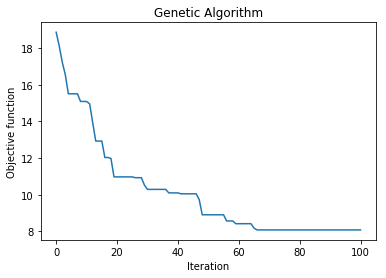

In [26]:
algorithm_param = {'max_num_iteration': 100,\
                   'population_size':100,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

ga_model=ga(function=fitness_function,dimension=len(weights_vector),variable_type='real',variable_boundaries=np.array(varbound), algorithm_parameters=algorithm_param)

ga_model.run()